In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### Question 1

In [2]:
cols = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

df = pd.read_csv('bank-full.csv' , delimiter=';' , usecols= cols)

In [3]:
df.shape

(45211, 15)

In [4]:
df.y = (df.y == 'yes').astype(int) 

In [5]:
df_full_train , df_test = train_test_split(df , test_size=0.2 , random_state=1)
df_train , df_val = train_test_split(df_full_train , test_size=0.25 , random_state=1)

In [6]:
len(df_train) , len(df_val) , len(df_test)

(27126, 9042, 9043)

In [7]:
num = [
    'balance',
    'day',
    'duration',
    'previous'
]

In [8]:
y_train = df_train.y.values
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
from sklearn.metrics import roc_auc_score

for n in num:
    score = roc_auc_score(y_train ,df_train[n] )
    print(n,score)

balance 0.5888313805382317
day 0.474042117616092
duration 0.8147002759670778
previous 0.5985653242764153


In [10]:
roc_auc_score(y_train ,df_train['balance'] )

0.5888313805382317

In [11]:
roc_auc_score(y_train ,-df_train['day'] )

0.525957882383908

In [12]:
roc_auc_score(y_train ,df_train['duration'] )

0.8147002759670778

In [13]:
roc_auc_score(y_train ,df_train['previous'] )

0.5985653242764153

#### Question 2

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [15]:
y_val=df_val.y.values
y_test=df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [16]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)
model.fit(X_train , y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [17]:
val_dicts = df_val.to_dict(orient='records')
X_val=dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:,1]
auc=roc_auc_score(y_val  , y_pred)
auc

0.8999780109216243

In [18]:
print( '%.2f'% auc)

0.90


#### Question 3

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [20]:
precision_score(y_val , y_pred >=0.8)

0.6851851851851852

In [21]:
threshold = np.linspace(0 ,1 , 101)
scores =[]
for t in threshold:
    p=precision_score(y_val , y_pred >=t)
    r=recall_score(y_val , y_pred >=t)
    scores.append((t,p,r))

/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
s=pd.DataFrame(scores , columns=['threshold','precision','recall'])
s

,threshold,precision,recall
0,0.00,0.121433,1.000000
1,0.01,0.135867,0.996357
2,0.02,0.159399,0.995446
3,0.03,0.186630,0.989071
4,0.04,0.220318,0.971767
...,...,...,...
96,0.96,0.653061,0.029144
97,0.97,0.625000,0.022769
98,0.98,0.687500,0.020036
99,0.99,0.625000,0.009107


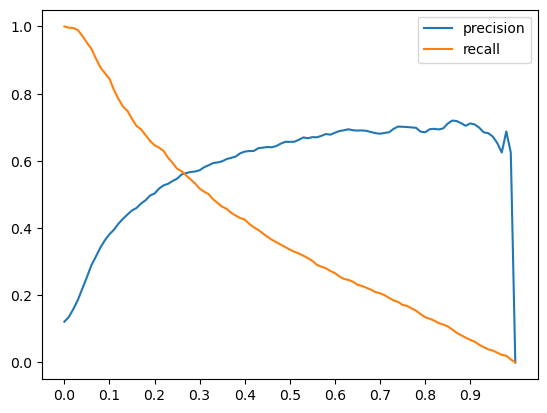

In [23]:
plt.plot(s.threshold,s['precision'] , label='precision')
plt.plot(s.threshold,s['recall'],label='recall')
plt.xticks(np.arange(0,1,0.1))
plt.legend()

#### Question 4 

In [24]:
s['f1'] = 2*((s['precision']*s['recall'])/(s['recall']+s['precision']))
s[s.f1==0.5736820257368203]

,threshold,precision,recall,f1
22,0.22,0.527079,0.629326,0.573682


#### Question 5 

In [25]:
def train(x ,y):
    x_dicts = x.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)

    X = dv.fit_transform(x_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

    model.fit(X,y)

    return dv , model 


In [26]:
def predict(validation , dv ,model):

    dicts = validation.to_dict(orient='records')

    X_val = dv.fit_transform(dicts)

    y_pred = model.predict_proba(X_val)[:,1]

    return y_pred
    

In [27]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for train_idx , val_idx in kfold.split(df_full_train):
    train_df = df_full_train.iloc[train_idx]
    val_df = df_full_train.iloc[val_idx]

    y_train = train_df.y.values
    y_val = val_df.y.values

    dv , model = train(train_df , y_train)

    pred_val = predict(val_df , dv , model)

    auc = roc_auc_score(y_val , pred_val)
    scores.append(auc)

scores

[0.9999994801659934, 1.0, 1.0, 1.0, 1.0]

In [28]:
print(' %.3f +- %.f' % ( np.mean(scores), np.std(scores)))

 1.000 +- 0


#### Question 6 

In [29]:
def train(df_train , y_train , c=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model=LogisticRegression(C=c , max_iter=3000)
    model.fit(X_train,y_train)

    return dv , model

In [30]:

c= [0.000001, 0.001, 1]


for i in c:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx , val_idx in kfold.split(df_full_train):
        train_df = df_full_train.iloc[train_idx]
        val_df = df_full_train.iloc[val_idx]

        y_train = train_df.y.values
        y_val = val_df.y.values

        dv , model = train(train_df , y_train , c=i)

        pred_val = predict(val_df , dv , model)

        auc = roc_auc_score(y_val , pred_val)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (i, np.mean(scores), np.std(scores)))

C=1e-06 0.824 +- 0.009


/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kazeka/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

C=0.001 0.991 +- 0.001
C=1 1.000 +- 0.000
